In [24]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


**Importing Necessary Libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import numpy as np

In [3]:
# Load dataset
df = pd.read_csv("./diagnostic_classes.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,-1.944044,1.891310,5.378017,-1.099764,0.319998,-0.107990,0.192998,-0.531588,-1.978358,0.505306,...,0.435838,-0.375777,-2.410484,1.307302,-0.447091,-1.205613,-0.758668,-1.115528,1.219782,8
1,0.548890,3.689146,-1.079215,-1.125497,6.892610,-0.114086,-0.129833,-4.471123,1.281707,2.509007,...,-0.515136,-1.814937,-0.659753,0.092014,1.173449,-0.887015,-0.657684,0.676340,0.379053,8
2,1.044743,2.804073,-1.779122,-0.358211,6.132624,-1.309396,-0.731316,-3.381683,-1.444734,3.028355,...,-0.928873,-1.592203,-0.389953,0.343527,0.740160,-0.244341,-1.337129,-0.168281,-0.464880,8
3,-2.848743,-2.220174,-0.498797,-0.054547,0.073406,0.927517,1.891807,-0.381548,0.017551,0.659493,...,0.662054,0.671306,-0.463003,-0.170516,0.249816,0.019505,-0.380889,-0.222127,0.364851,8
4,-0.715628,0.217362,2.032461,-0.144826,4.375660,-1.762026,1.335940,1.742721,-1.771379,0.819612,...,-0.428352,-0.511074,-0.346423,0.137622,-0.289325,-1.089344,-0.407556,-0.007071,0.117600,8


In [4]:
print(df['target'].value_counts())

target
8     367
3      80
14     27
2      16
1      15
0      15
7       7
13      6
9       4
11      2
4       1
5       1
10      1
6       1
12      1
Name: count, dtype: int64


In [5]:
# Splitting features and target
X = df.drop(columns=['target'])  # Replace 'target' with actual target column name
y = df['target']

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Print class distribution before oversampling
print("Class distribution before oversampling:", Counter(y_train))

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Print new class distribution
print("Class distribution after oversampling:", Counter(y_train_resampled))


Class distribution before oversampling: Counter({8: 289, 3: 65, 14: 19, 0: 15, 2: 14, 1: 11, 7: 6, 13: 6, 9: 4, 11: 2, 12: 1, 6: 1, 10: 1, 4: 1})
Class distribution after oversampling: Counter({8: 289, 2: 289, 3: 289, 0: 289, 14: 289, 9: 289, 7: 289, 13: 289, 1: 289, 12: 289, 11: 289, 6: 289, 10: 289, 4: 289})


**Logistic Regression - SKLearn Library**

In [19]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_resampled = encoder.fit_transform(y_train_resampled)
y_test = encoder.transform(y_test)

ValueError: y contains previously unseen labels: [np.int64(5)]

In [8]:
# Logistic Regression Model
model = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=500)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [9]:
import numpy as np

print("Unique labels in y_test:", np.unique(y_test))
print("Unique labels in y_pred:", np.unique(y_pred))

Unique labels in y_test: [ 1  2  3  5  7  8 14]
Unique labels in y_pred: [ 0  1  2  3  7  8  9 10 13 14]


In [10]:
# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred,zero_division=1))

Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       0.00      0.00      0.00         4
           2       0.17      0.50      0.25         2
           3       0.77      0.67      0.71        15
           5       1.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.99      0.87      0.93        78
           9       0.00      1.00      0.00         0
          10       0.00      1.00      0.00         0
          13       0.00      1.00      0.00         0
          14       0.86      0.75      0.80         8

    accuracy                           0.78       109
   macro avg       0.34      0.62      0.24       109
weighted avg       0.89      0.78      0.82       109



In [11]:
# Evaluation Metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  0  1  0  0  1  0  0]
 [ 0  0  1  0  0  0  0  0  1  0  0]
 [ 1  0  3 10  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 1  3  1  2  0  0 68  0  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  1  0  6]]


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_pred)
num_classes = cm.shape[0]  # Number of classes

# Initialize lists to store sensitivity & specificity per class
sensitivities = []
specificities = []

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall for class i
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # True negative rate for class i
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    print(f"Class {i}: Sensitivity (Recall) = {sensitivity:.4f}, Specificity = {specificity:.4f}")

# Average Sensitivity and Specificity (macro-average)
macro_sensitivity = np.mean(sensitivities)
macro_specificity = np.mean(specificities)

print(f"\nMacro Sensitivity: {macro_sensitivity:.4f}")
print(f"Macro Specificity: {macro_specificity:.4f}")

Class 0: Sensitivity (Recall) = 0.0000, Specificity = 0.9817
Class 1: Sensitivity (Recall) = 0.0000, Specificity = 0.9524
Class 2: Sensitivity (Recall) = 0.5000, Specificity = 0.9533
Class 3: Sensitivity (Recall) = 0.6667, Specificity = 0.9681
Class 4: Sensitivity (Recall) = 0.0000, Specificity = 1.0000
Class 5: Sensitivity (Recall) = 0.0000, Specificity = 0.9907
Class 6: Sensitivity (Recall) = 0.8718, Specificity = 0.9677
Class 7: Sensitivity (Recall) = 0.0000, Specificity = 0.9908
Class 8: Sensitivity (Recall) = 0.0000, Specificity = 0.9633
Class 9: Sensitivity (Recall) = 0.0000, Specificity = 0.9908
Class 10: Sensitivity (Recall) = 0.7500, Specificity = 0.9901

Macro Sensitivity: 0.2535
Macro Specificity: 0.9772


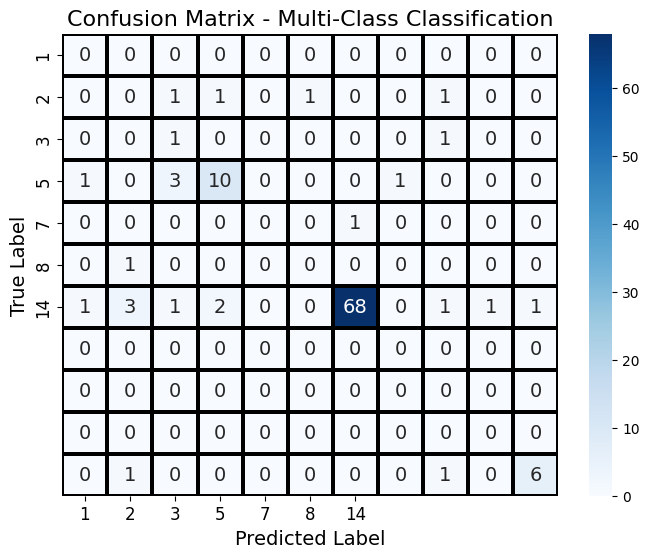

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Example: Assume y_true and y_pred are multi-class labels
classes = np.unique(y_test)  # Get class labels dynamically
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))  # Adjust size for multi-class
ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues',
                 linewidths=1.5, linecolor='black',
                 annot_kws={"size": 14},
                 xticklabels=classes,  # Use dynamic labels
                 yticklabels=classes)

plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix - Multi-Class Classification", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [18]:
print(np.unique(y_train_resampled))

[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14]


In [17]:
print(y_prob.shape)

(109,)


In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # For colors

# Binarize y_test for one-vs-rest ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)  
n_classes = len(classes)

# Ensure y_prob is correctly shaped
if y_prob.ndim == 1 or y_prob.shape[1] != n_classes:
    raise ValueError(f"Expected y_prob to have {n_classes} columns, but got shape {y_prob.shape}")

# Generate distinct colors
colors = sns.color_palette("tab10", n_classes)

# Plot ROC for each class
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])  
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# Diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Labels and Title
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Multiclass ROC Curve", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

ValueError: Expected y_prob to have 7 columns, but got shape (109,)